<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up(Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

The goal is to beat original Food101 paper with 10% of the trainig data using deep learning

In [1]:
!nvidia-smi

Sat Dec 28 05:41:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## creating helper functions.

In previous notebook, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-28 05:41:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-28 05:41:36 (73.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions in notebook.

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

our goal is to beat original Food101 paper with 10% of the trainig data using deep learning.

The data we're downloading comes from original Food101 dataset but has been processed using image_data_modifications notebook in github.


In [4]:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")


train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-12-28 05:41:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  16.1MB/s    in 95s     

2024-12-28 05:43:23 (16.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many image/classes are there ?.

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories an

In [6]:
# Setup data inputs.

import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size = IMG_SIZE,)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle=False # don't shuffle the test data for prediction analysis.
                                                                )


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes.

Here are the steps we're going to take:
* Create a ModelCheckpoint callback.
* Create a data augmentation layer to biuld data augmentation right into the model
* Build a headless(no top layer) efficientNetB0 backboned-model(we'll create our own layer)
* Compile our model
* Feature extract for 5 full passes


In [7]:
# Create a Checkpoint callback.

checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only = True     # Save only the highest accuracy
                                                         )

In [8]:
  # Create data augmentation layer to incorporate it right into the model.
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomHeight(0.2),
      layers.RandomWidth(0.2),
      layers.RandomZoom(0.2),
      # layers.experimental.preprocessing.Rescaling(1/255.) # Skip this when using EfficientNetB0 bcause it is already build in. But for ResNet50 include it.
  ], name="data_augmentation")

 ## Model 1: Feature Extraction Transfer Learning with 10% of the data using Data Augmentation

In [9]:
# Setup input shpae and base model, freezing the base model layers.

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False
)
base_model.trainable = False

# Create input layer.
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation sequential model as a layer.
x = data_augmentation(inputs)  # augment image

# Give the base model the inputs (after augmentation) and don't train it.
x = base_model(x, training=False)

# Pool out features of the base model.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer.
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs=inputs, outputs = outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
# Compile the model.
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
history_all_classes_10_percent = model.fit(
    train_data_all_10_percent.repeat(),
    epochs = 5,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),   # Validate on 15% of the data during training
    callbacks = [checkpoint_callback]
)

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.1295 - loss: 4.0811 - val_accuracy: 0.3784 - val_loss: 2.7893
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.4200 - loss: 2.5841 - val_accuracy: 0.4526 - val_loss: 2.2492
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.4907 - loss: 2.1614 - val_accuracy: 0.5561 - val_loss: 1.8549
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.5318 - loss: 1.9412 - val_accuracy: 0.5569 - val_loss: 1.7942
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.5562 - loss: 1.8045 - val_accuracy: 0.5794 - val_loss: 1.6991


In [11]:
# Evaluate on the whole test dataset.
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.5071 - loss: 1.9139


[1.8323930501937866, 0.529306948184967]

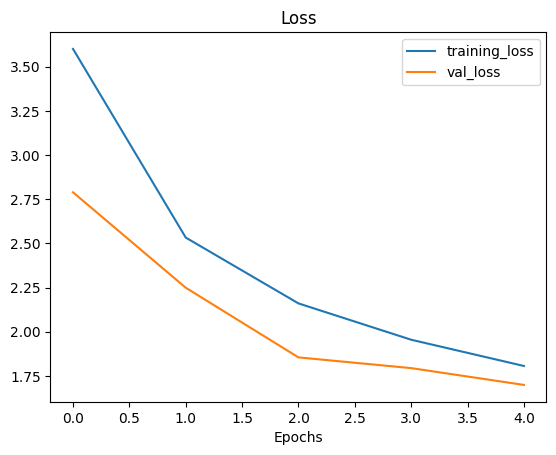

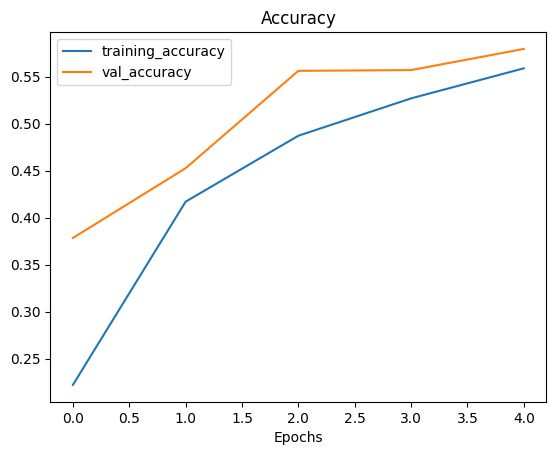

In [12]:
# Plot loss curves.

plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [13]:
# Unfreeze all of the layers in the base model

base_model.trainable = True

# Refreeze every layer except for the last 5.
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [14]:
# Recompile model with lower learning rate.....
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy"]
)

In [15]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [16]:
 # Check which layers are trainable in our base model.
 for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [17]:
# Fine-tune for more epochs.

fine_tune_epochs = 10  # we have done 5 epochs for feature extraction. let add another 5 for fine-tuning.

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_percent.repeat(),
    epochs = fine_tune_epochs,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = history_all_classes_10_percent.epoch[-1],   # Continue training where you finish in the feature extraction model.
    callbacks = [checkpoint_callback]
)

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 180ms/step - accuracy: 0.5746 - loss: 1.7588 - val_accuracy: 0.4958 - val_loss: 1.9638
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.6149 - loss: 1.5606 - val_accuracy: 0.5339 - val_loss: 1.7532
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.6464 - loss: 1.4710 - val_accuracy: 0.5969 - val_loss: 1.6045
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.6464 - loss: 1.4067 - val_accuracy: 0.5697 - val_loss: 1.6274
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 164ms/step - accuracy: 0.6741 - loss: 1.3383 - val_accuracy: 0.6284 - val_loss: 1.4416
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.6810 - loss: 1.2668 - val_accuracy: 0.6065 - val_loss: 1.4396


In [18]:
# Evaluate oon the whole test dataset.
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.5491 - loss: 1.7144


[1.6142358779907227, 0.5731484889984131]

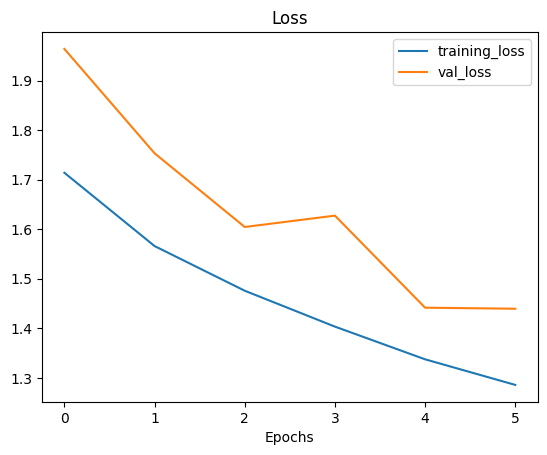

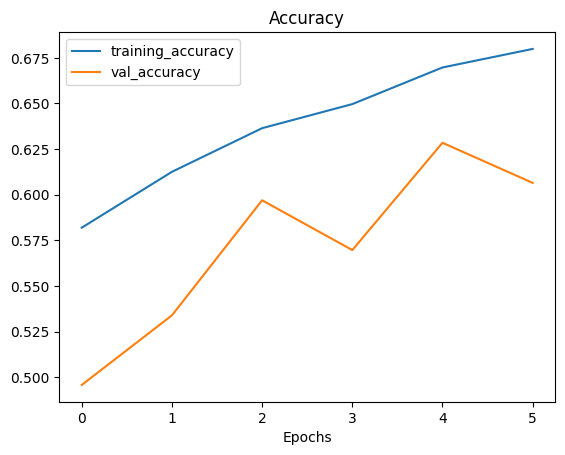

In [19]:
# plot loss curves.
plot_loss_curves(history_all_classes_10_percent_fine_tune)

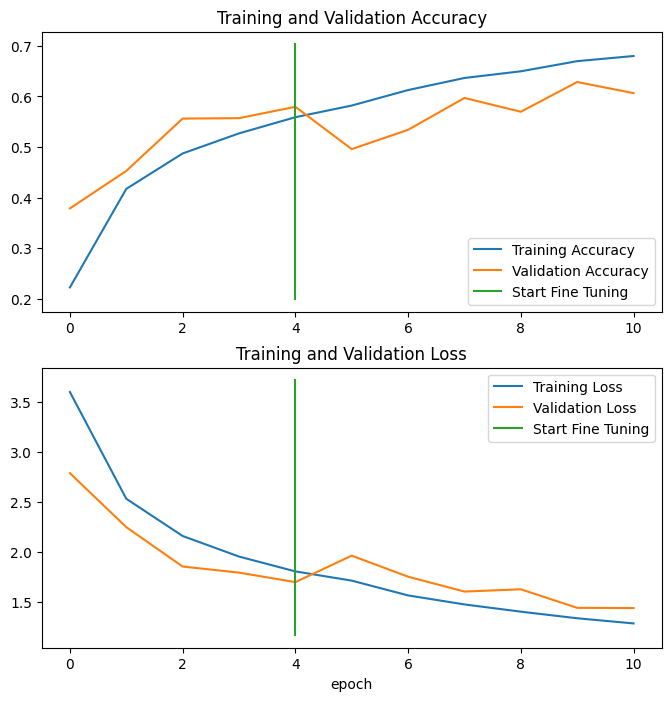

In [20]:
# Compare history of feature extraction model with fine-tuning model.
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

## Saving and loading our model.

To use our model in an external application, we'll need to save and load it somehow.

## Evaluating the performance of the big dog model across all different classes.

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [21]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-12-28 05:54:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  13.5MB/s    in 3.5s    

2024-12-28 05:54:30 (12.7 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [22]:
# Download pretrain model. one prepared earlier so all predictions are similar.
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [23]:
# # Load in save model
# from tensorflow.keras.layers import TFSMLayer
# from tensorflow import keras

# # model = TFSMLayer("/content/06_101_food_class_10_percent_saved_big_dog_model", call_endpoint='serving_default')
# # model

# model = keras.layers.TFSMLayer(
#     "/content/06_101_food_class_10_percent_saved_big_dog_model",
#     call_endpoint="serving_default",  # Change call_endpoint to 'serving_default'
# )

In [24]:
import tf_keras as k3

# Load in saved model.
model = k3.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")
model

In [25]:
# Evaluate the loaded model.
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 53s 66ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

 ## Making predictions with our trained model

In [26]:
# Make predictions with our model.

preds_probs = model.predict(test_data, verbose=1)  # to set verbosity to see how long is left
preds_probs

790/790 [==============================] - 56s 69ms/step


array([[5.9542213e-02, 3.5742137e-06, 4.1377041e-02, ..., 1.4138676e-09,
        8.3530962e-05, 3.0897709e-03],
       [9.6401680e-01, 1.3753220e-09, 8.4780209e-04, ..., 5.4287098e-05,
        7.8361918e-12, 9.8465835e-10],
       [9.5925879e-01, 3.2533775e-05, 1.4866964e-03, ..., 7.1891412e-07,
        5.4397583e-07, 4.0275929e-05],
       ...,
       [1.5138730e-05, 4.0973083e-04, 8.0250656e-10, ..., 2.1742862e-05,
        1.0797197e-05, 5.3789884e-01],
       [5.9318091e-03, 4.9236771e-03, 9.9823242e-03, ..., 1.1989498e-04,
        1.6890262e-05, 4.5218047e-02],
       [3.1363465e-02, 7.5052362e-03, 4.2975091e-04, ..., 5.0346385e-04,
        5.2056080e-06, 6.9062859e-01]], dtype=float32)

In [27]:
# What is shape of our predictions ?.
preds_probs.shape, len(test_data)

((25250, 101), 790)

In [28]:
# Let's see what the first 10 predictions look like.
preds_probs[:10]

array([[5.9542213e-02, 3.5742137e-06, 4.1377041e-02, ..., 1.4138676e-09,
        8.3530962e-05, 3.0897709e-03],
       [9.6401680e-01, 1.3753220e-09, 8.4780209e-04, ..., 5.4287098e-05,
        7.8361918e-12, 9.8465835e-10],
       [9.5925879e-01, 3.2533775e-05, 1.4866964e-03, ..., 7.1891412e-07,
        5.4397583e-07, 4.0275929e-05],
       ...,
       [4.7313288e-01, 1.2931191e-07, 1.4805571e-03, ..., 5.9750077e-04,
        6.6969005e-05, 2.3469400e-05],
       [4.4571895e-02, 4.7265519e-07, 1.2258518e-01, ..., 6.3498619e-06,
        7.5318503e-06, 3.6778899e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [29]:
# What does the first prediction probability look like.

preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95422126e-02, 3.57421368e-06, 4.13770415e-02, 1.06606324e-09,
        8.16142531e-09, 8.66396288e-09, 8.09274070e-07, 8.56529539e-07,
        1.98591606e-05, 8.09774235e-07, 3.17277338e-09, 9.86737973e-07,
        2.85322894e-04, 7.80490172e-10, 7.42304197e-04, 3.89164816e-05,
        6.47405386e-06, 2.49774143e-06, 3.78911900e-05, 2.06782616e-07,
        1.55384460e-05, 8.15073861e-07, 2.62306344e-06, 2.00106967e-07,
        8.38279050e-07, 5.42160706e-06, 3.73909870e-06, 1.31505775e-08,
        2.77615804e-03, 2.80519871e-05, 6.85621337e-10, 2.55748728e-05,
        1.66889717e-04, 7.64069696e-10, 4.04530176e-04, 1.31506805e-08,
        1.79573726e-06, 1.44482397e-06, 2.30628941e-02, 8.24670678e-07,
        8.53659003e-07, 1.71386728e-06, 7.05256207e-06, 1.84021616e-08,
        2.85534497e-07, 7.94839616e-06, 2.06815457e-06, 1.85251992e-07,
        3.36197594e-08, 3.15226032e-04, 1.04109295e-05, 8.54483289e-07,
        8.47418368e-01, 1.05554509e-05, 4.40948213e-07, 3.740417

Our model outputs a prediction probalility array (With N number of variables, where N is the number of classes) for each prediction.

In [30]:
# We get one prediction prob per class (in our case there's 101 prediction probaility per class)

print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95422126e-02 3.57421368e-06 4.13770415e-02 1.06606324e-09
 8.16142531e-09 8.66396288e-09 8.09274070e-07 8.56529539e-07
 1.98591606e-05 8.09774235e-07 3.17277338e-09 9.86737973e-07
 2.85322894e-04 7.80490172e-10 7.42304197e-04 3.89164816e-05
 6.47405386e-06 2.49774143e-06 3.78911900e-05 2.06782616e-07
 1.55384460e-05 8.15073861e-07 2.62306344e-06 2.00106967e-07
 8.38279050e-07 5.42160706e-06 3.73909870e-06 1.31505775e-08
 2.77615804e-03 2.80519871e-05 6.85621337e-10 2.55748728e-05
 1.66889717e-04 7.64069696e-10 4.04530176e-04 1.31506805e-08
 1.79573726e-06 1.44482397e-06 2.30628941e-02 8.24670678e-07
 8.53659003e-07 1.71386728e-06 7.05256207e-06 1.84021616e-08
 2.85534497e-07 7.94839616e-06 2.06815457e-06 1.85251992e-07
 3.36197594e-08 3.15226032e-04 1.04109295e-05 8.54483289e-07
 8.47418368e-01 1.05554509e-05 4.40948213e-07 3.74041701e-05
 3.53062496e-05 3.24890570e-05 6.73149116e-

In [31]:
# Get the pred classes of each label.
pred_classes = preds_probs.argmax(axis=1)

# How do they look ?.
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [32]:
# How many pred_clases do we have.
len(pred_classes)

25250

Now we got a predictions array of all of our models' prediction, to evaluate them we need to compare them to the original test dataset

In [33]:
# To get our test labels we need to unravel our test_data BatchDataset.

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
  # print(images.shape, labels)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:
# How many y_labels are ther ?.

len(y_labels)

25250

## Evalating our model's predictions.

one way to check that our model prediction's array is in the same order as our test labels array is. To find the accuracy score.

In [35]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [36]:
# Let's try sklearn accuracy score function and see what we have....

from sklearn.metrics import accuracy_score, confusion_matrix

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [38]:
# Does this metric come close to our model's evaluate results..
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [39]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sklearn_confusion_matrix = confusion_matrix(
    y_true = y_labels,
    y_pred = pred_classes,
    # labels = class_names
    )
plt.figure(figsize=(100,100))
sklearn_confusion_matrix
sns.heatmap(sklearn_confusion_matrix, annot=True)


<Axes: >

In [41]:
# Lets evaluate further with classification report to see how it work..

from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [42]:
# Get a dic of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.5440806045340051,
  'support': 250.0},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.4186046511627907,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'sup

# Let's plot all of our classes F1-scores..



In [43]:
# create empty dict
class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713755,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5440806045340051,
 'beet_salad': 0.4186046511627907,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056105,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.3674418604651163,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.4526166902404526,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.46255506607929514,
 'creme_brulee'

In [44]:
# Turn F1-score into a DF for visualization.
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1_scores': list(class_f1_scores.values())}).sort_values("f1_scores", ascending=False)
f1_scores

,class_names,f1_scores
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


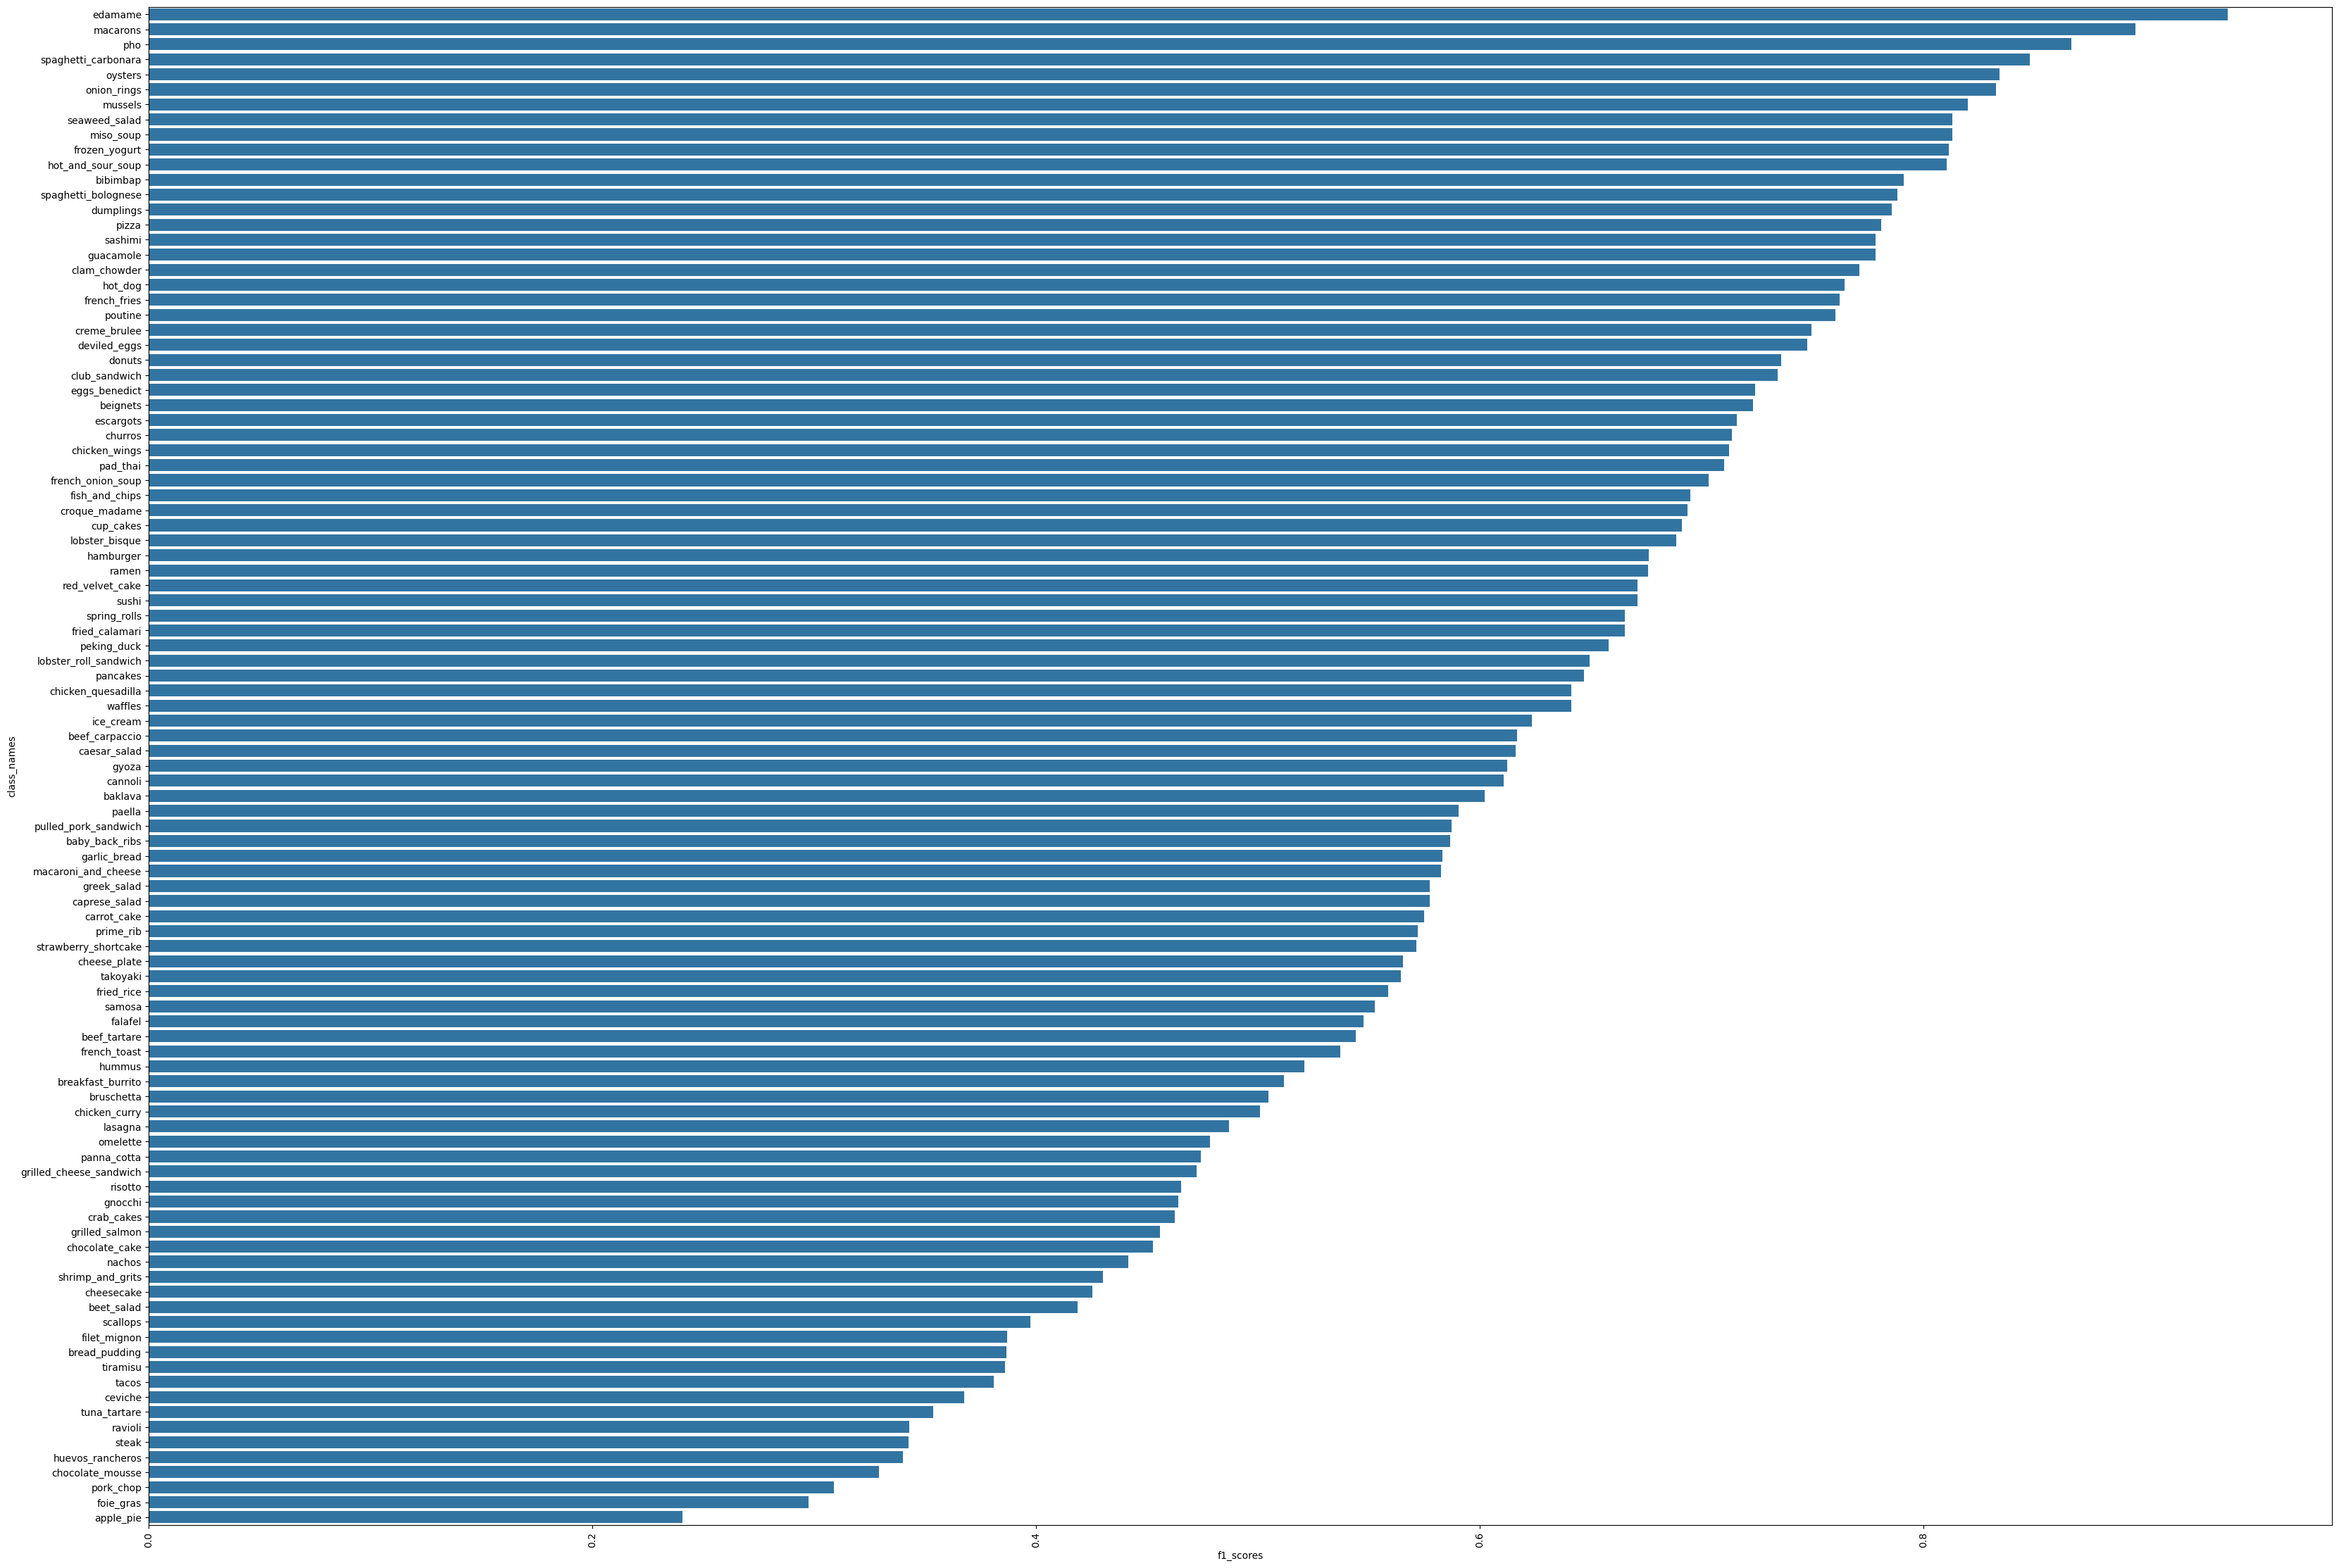

In [45]:
plt.figure(figsize=(40,28))
sns.barplot(data=f1_scores, y='class_names', x='f1_scores')
plt.xticks(rotation=90);

 ## Visualizing predictions on custom images.
 Now, this is the real test, how does our model go on food images note even in our test dataset(images of our own).

 To visualize our model's preidiction on our own images,, we'll need a function to load and preprocess images, specificallly it will need to.

 * Read in a target image filepath using tf.io.read_file()
 * Turn the image into a Tensor using tf.io.decode_image()
 * Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize().
 * Scale the image to get all of the pixel values between 0 and 1 (if neccessary).


In [50]:
# Create a function to load and prepre images.

def load_and_prep_image(file_name, image_shape=224, scale=True):
  """
    Read in an image from filename, turns it into a tensor and reshapes into specified shape (image_shape, img_hspae, colo_channels=3)..

    Args:
      filename (str): path to target image
      image_shape(int): height/width dimension of target image size
      scale (bool): scale pixel values from 0-255 to 0-1 or not

    Returns:
      Image tensor of shape (image_shape, image_shape, 3)
  """

  # Read in the image.
  img = tf.io.read_file(file_name)

  # Deocde image into tensor.
  img = tf.io.decode_image(img, channels = 3)

  # Resize the image.
  img = tf.image.resize(img, [image_shape, image_shape])

  # Scale? Yes/no (Data normalization)
  if scale:
    return img/255.
  else:
    return img

In [51]:
## Calling the function..
# load_and_prep_image("https://media.istockphoto.com/id/1397479529/photo/asian-chicken-fried-rice-with-chopsticks-directly-above-photo.jpg?s=2048x2048&w=is&k=20&c=iR8MGwzwrmVxUPllPsRHgznqF28qyM_Q5aqOOrN-qJY=")

1/1 [==============================] - 0s 31ms/step


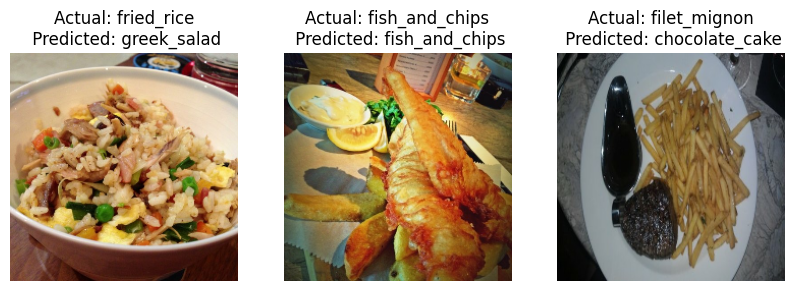

In [62]:
# Make prediction on a series of random images.
import os
import random

plt.figure(figsize=(10,10))

for i in range(3):
  # Choose an image from a random classes.
  class_name = random.choice(class_names)
  class_dir = os.path.join(test_dir, class_name)
  file_name = random.choice(os.listdir(class_dir))
  filepath = test_dir + class_name + "/" + file_name

  # Load the image and make predictions.
  # img = load_and_prep_image(filepath)
  # print(filepath)

  # Load the image and make predictions.
  img = load_and_prep_image(filepath, scale=False)  # Scale False b/c we are using EfficientNetB0
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}\n Predicted: {pred_class}")
  plt.axis(False);

In [ ]:
## Finding the most wrong prediction output